# Определение стоимости автомобилей¶

<b>Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. <b>

Заказчику важны:

- качество предсказания;
    
- скорость предсказания;
    
- время обучения.

<b>В моем распоряжении данные о технических характеристиках, комплектации и ценах других авто-мобилей.

Задача: построить модель, которая умеет определять стоимость автомобиля.
    
Для целей исследования я собираюсь изучить данные, проанализировать их. подготовить к обучению и обучить пять моделей, а затем сравнить их характеристики: время обучения, время предсказания, точность результата.

Точность модели я буду оценивать по метрике RMSE по условиям задачи она должа быть менее 2500.<b/>

<b>Признаки: <b/>
    
    •	DateCrawled — дата скачивания анкеты из базы
    
    •	VehicleType — тип автомобильного кузова
    
    •	RegistrationYear — год регистрации автомобиля
    
    •	Gearbox — тип коробки передач
    
    •	Power — мощность (л. с.)
    
    •	Model — модель автомобиля
    
    •	Kilometer — пробег (км)
    
    •	RegistrationMonth — месяц регистрации автомобиля
    
    •	FuelType — тип топлива
    
    •	Brand — марка автомобиля
    
    •	Repaired — была машина в ремонте или нет
    
    •	DateCreated — дата создания анкеты
    
    •	NumberOfPictures — количество фотографий автомобиля
    
    •	PostalCode — почтовый индекс владельца анкеты (пользователя)
    
    •	LastSeen — дата последней активности пользователя
    

<b>Целевой признак:<b/>
    
    •	Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

import lightgbm as lgbm
from lightgbm import LGBMRegressor
import catboost as cb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<b>Приведу названия всех столбцов к нижнему регистру и проверю на пропуски.<b/>

In [3]:
df.columns = map(str.lower, df.columns)
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
repaired             71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

<b>Пропуски в столбце notrepaired (была машина в ремонте или нет) нет возможности заполнить анаолгичными значениями, поэтому предполагаю, что лучшим вариантом в данном случае будет заполнение пропусков значением "unknown". Модель я попробую восстановить по сочетанию парметров бренда и мощности.<b/>

In [5]:
df['repaired'] = df['repaired'].fillna('unknown')

In [6]:
df['model'] = df.groupby(
    ['brand', 'power'])['model'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [7]:
medians  = df.groupby('model')['power'].median().to_dict()
def fill_with_median (row):
    if row['power'] == 0:
        return medians [row['model']]
    return row ['power']
df['power'] = df.apply(lambda row: fill_with_median(row), axis = 1)

<b>Пропуски в столбце vehicletype, gearbox и fueltype можно заполнить по столбцу model, потому что у моделей должны быть одинаковые тип кузова, коробка передач и тип топлива.<b/>

In [8]:
df['vehicletype'] = df.groupby(['model','brand'], sort=True)['vehicletype'].apply(lambda x: x.ffill())
df['gearbox'] = df.groupby(['model','brand'], sort=True)['gearbox'].apply(lambda x: x.ffill())
df['fueltype'] = df.groupby(['model','brand'], sort=True)['fueltype'].apply(lambda x: x.ffill())

In [9]:
df.isna().sum()

datecrawled           0
price                 0
vehicletype          53
registrationyear      0
gearbox              29
power                 0
model                 0
kilometer             0
registrationmonth     0
fueltype             51
brand                 0
repaired              0
datecreated           0
numberofpictures      0
postalcode            0
lastseen              0
dtype: int64

<b>Осталось небольшое количество пропусков, которые не получилось заполнить по соответствующим моделям, я их удалю.<b/>

In [10]:
df = df.dropna().reset_index()

In [11]:
df.isna().sum()

index                0
datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
repaired             0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

## Анализ данных.

<b>Исследую данные по каждому параментру отдельно.<b/>

Такие параментры, как datecrawled, datecreated, postalcode и lastseen не являются важными для определения цены автомобиля.
Поэтому я не буду их изучать, а просто удалю, когда буду готовить данные для обучения моделей. 

In [12]:
columns = df.columns.values.tolist()

In [13]:
for col in columns:
    print(col)
    print(df[col].describe())
    print('***')

index
count    354278.000000
mean     177225.860536
std      102276.264431
min           1.000000
25%       88656.250000
50%      177229.500000
75%      265798.750000
max      354368.000000
Name: index, dtype: float64
***
datecrawled
count                  354278
unique                 271125
top       2016-03-24 14:49:47
freq                        7
Name: datecrawled, dtype: object
***
price
count    354278.000000
mean       4417.178659
std        4514.314158
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64
***
vehicletype
count     354278
unique         8
top        sedan
freq      102140
Name: vehicletype, dtype: object
***
registrationyear
count    354278.000000
mean       2004.235603
std          90.237933
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64
***
gearbox
count     354278
u

In [14]:
for col in columns:
    print(col)
    print(df[col].value_counts())
    print('***')

index
2049      1
124310    1
107934    1
114077    1
112028    1
         ..
269014    1
262869    1
264916    1
275155    1
2047      1
Name: index, Length: 354278, dtype: int64
***
datecrawled
2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-23 13:50:19    5
2016-03-22 10:42:10    5
                      ..
2016-04-01 13:47:18    1
2016-03-25 18:54:55    1
2016-04-02 13:45:02    1
2016-03-08 17:49:34    1
2016-04-02 21:55:34    1
Name: datecrawled, Length: 271125, dtype: int64
***
price
0        10765
500       5668
1500      5393
1000      4648
1200      4593
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64
***
vehicletype
sedan          102140
small           91198
wagon           71474
bus             32484
convertible     22319
coupe           17896
suv             12918
other            3849
Name: vehicletype, dtype: int64
***
registrationyear
2000    24484
1999   

<b>В колонке количество фотографий все значения равны нулю, это значит, что ее тоже можно удалять.<b/>

<b>В колонеке год регистрации есть очень сильные выбросы и явные ошибки, так как год регистрации восстановить никак нельзя, а такие аномалии могут помешать обучению, я их удалю.<b/>

In [15]:
df = df.query('registrationyear >= 1980 and registrationyear < 2016')

In [16]:
df['registrationyear'].value_counts()

2000    24484
1999    22727
2005    22106
2001    20123
2006    19893
2003    19760
2004    19607
2002    19091
1998    17895
2007    17183
2008    15390
1997    14665
2009    14500
1996    10833
2010    10764
2011     9909
1995     9602
2012     7176
1994     4840
2013     4130
1993     3437
1992     3001
1990     2804
1991     2761
2014     2537
1989     1318
2015     1301
1988      941
1985      754
1987      667
1980      588
1986      537
1983      430
1984      399
1982      316
1981      263
Name: registrationyear, dtype: int64

<b>Изучу подробнее целевой признак price.<b/>

In [17]:
df['price'].describe()

count    326732.000000
mean       4516.504426
std        4545.217633
min           0.000000
25%        1111.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

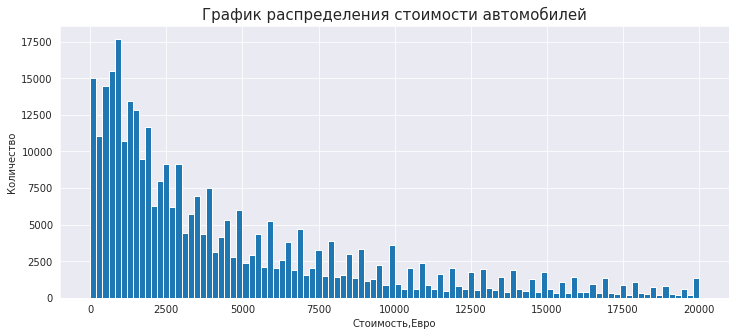

In [18]:
sns.set_style('darkgrid')
df['price'].hist(bins=100,figsize=(12,5))
plt.title('График распределения стоимости автомобилей', fontsize=15)
plt.xlabel('Стоимость,Евро', fontsize=10)
plt.ylabel('Количество', fontsize=10)
plt.show()

<b>Есть много значений в районе 0, возможно это ошибки, их лучше удалить, чтобы обучение было более корректным. Данное распределение данных говорит о том, что количество дорогих машин, выставленных на продажу, меньше в процентном соотношении, чем машин по средней цене.<b/>

In [19]:
df = df.query('price > 2')
df=df.reset_index(drop=True)

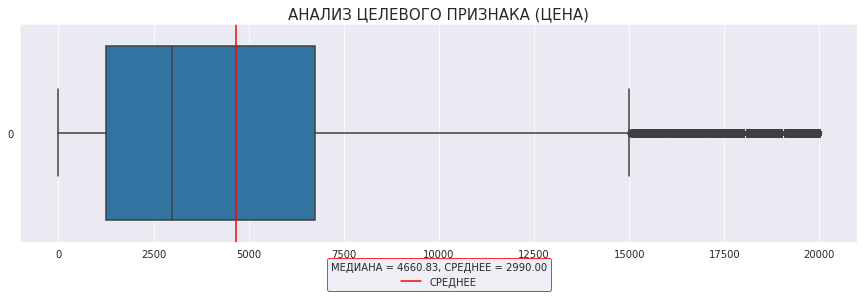

In [20]:
plt.figure(figsize=[15, 4])
plt.title(f'АНАЛИЗ ЦЕЛЕВОГО ПРИЗНАКА (ЦЕНА)', fontsize=15)
sns.boxplot(data=df['price'], orient='h')
plt.axvline(np.mean(df['price']), 
            color='r', 
            linestyle='-',
            label='СРЕДНЕЕ')
median = np.mean(df['price'])
mean = np.median(df['price'])
plt.legend(title=f'МЕДИАНА = {median:.2f}, СРЕДНЕЕ = {mean:.2f}', 
           loc='center', 
           edgecolor = 'r',          
           bbox_to_anchor=(0.5, -0.15));

<b>Медиана и среднее значение отличаются довольно сильно, а также имеется много выбросов.<b/>

## Обучение моделей

<b>Разделю данные на признаки и целевой признак, а также удалю данные, которые не нужны для предсказания цены, это datecrawled, postalcode, , numberofpictures, datecreated и lastseen.<b/>

In [21]:
features = df.drop(['price', 'datecrawled', 'postalcode', 'lastseen', 'datecreated', 'numberofpictures'], axis=1)
target = df['price']

In [22]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316614 entries, 0 to 316613
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              316614 non-null  int64  
 1   vehicletype        316614 non-null  object 
 2   registrationyear   316614 non-null  int64  
 3   gearbox            316614 non-null  object 
 4   power              316614 non-null  float64
 5   model              316614 non-null  object 
 6   kilometer          316614 non-null  int64  
 7   registrationmonth  316614 non-null  int64  
 8   fueltype           316614 non-null  object 
 9   brand              316614 non-null  object 
 10  repaired           316614 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 26.6+ MB


<b>6 из 10 независимых признаков имеют тип object, то есть являются категориальными. Для того чтобы использовать эти данные в обучении моделей, их нужно преобразовать. <b/>

In [23]:
features_ohe = pd.get_dummies(features, drop_first=True)

<b>Разделю данные на три выборки: обучающую, валидационную и тестовую.<b/>

In [24]:
features_study, features_test, target_study, target_test = train_test_split(
    features_ohe, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_study, target_study, test_size=0.25, random_state=12345)

In [25]:
scaler = StandardScaler()
quanti_columns = ['registrationyear', 'power', 'kilometer']
scaler.fit(features_train[quanti_columns])
features_train[quanti_columns] = scaler.transform(features_train[quanti_columns])
features_valid[quanti_columns]=scaler.transform(features_valid[quanti_columns])
features_test[quanti_columns] = scaler.transform(features_test[quanti_columns])

### Линейная регрессия.

In [26]:
start_lr_s = time.time()
model = LinearRegression().fit(features_train, target_train)
model.fit(features_train,target_train)
end_lr_s = time.time()

start_lr_p = time.time()
pred_lr = model.predict(features_valid)
end_lr_p = time.time()

result_lr = mean_squared_error(target_valid, pred_lr)**0.5 

t_lr_s = round(end_lr_s-start_lr_s,2)
t_lr_p = round(end_lr_p-start_lr_p,2)
print('RMSE модели Линейная регрессия:', result_lr)
print('Время обучения модели Линейная регрессия:', t_lr_s)
print('Время предсказания модели Линейная регрессия:', t_lr_p)

RMSE модели Линейная регрессия: 2524.8658065352392
Время обучения модели Линейная регрессия: 38.54
Время предсказания модели Линейная регрессия: 0.2


### Создание класса линейной регрессии.

In [27]:
%%time
class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)        
        y = train_target
        w = np.zeros(X.shape[1])
        
        for _ in range(self.epochs):
            batches_count = len(train_features) // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                
                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0] 
                
                w -= self.step_size * gradient

        self.w = w[1:]
        self.w0 = w[0]
        self.batches_count = batches_count
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0 

CPU times: user 118 µs, sys: 72 µs, total: 190 µs
Wall time: 34.8 µs


In [28]:
start_lr_c_s = time.time()
model_lr_c = SGDLinearRegression(10**-13, 10, 100)
model_lr_c.fit(features_train, target_train)
end_lr_c_s = time.time()

start_lr_c_p = time.time()
pred_lr_c = model_lr_c.predict(features_valid)
end_lr_c_p= time.time()

result_lr_c = mean_squared_error(target_valid, pred_lr_c)**0.5

t_lr_c_s = round(end_lr_c_s-start_lr_c_s,2)
t_lr_c_p = round(end_lr_c_p-start_lr_c_p,2)
print('RMSE модели Линейная регрессия:', result_lr_c)
print('Время обучения модели Линейная регрессия:', t_lr_c_s)
print('Время предсказания модели Линейная регрессия:', t_lr_c_p)

RMSE модели Линейная регрессия: 5091.131552594877
Время обучения модели Линейная регрессия: 101.7
Время предсказания модели Линейная регрессия: 0.21


### Случайный лес.

In [29]:
col=['vehicletype', 'gearbox','model',
       'fueltype', 'brand', 'repaired']

encoder = OrdinalEncoder()
encoder.fit(features[col])
features_ord=features.copy()
features_ord[col]= pd.DataFrame(encoder.transform(features[col]), columns = features[col].columns)

In [30]:
features_study_gb, features_test_gb, target_study_gb, target_test_gb = train_test_split(
    features_ord, target, test_size=0.2, random_state=12345)

features_train_gb, features_valid_gb, target_train_gb, target_valid_gb = train_test_split(
    features_study_gb, target_study_gb, test_size=0.25, random_state=12345)

In [31]:
%%time
grid = { 
    'n_estimators': range(50, 150, 50),
    'max_depth' : range (5, 20, 5),
    'random_state' : [12345]
}

rf_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv=3, scoring='neg_mean_squared_error')
rf_cv.fit(features_train, target_train)
best_grid = rf_cv.best_params_
print('лучшие параметры:', rf_cv.best_params_)

лучшие параметры: {'max_depth': 15, 'n_estimators': 100, 'random_state': 12345}
CPU times: user 28min 48s, sys: 8.32 s, total: 28min 57s
Wall time: 28min 58s


In [32]:
start_f_s = time.time()
model_f = RandomForestRegressor(**best_grid)
model_f.fit(features_train_gb, target_train_gb)
end_f_s = time.time()
start_f_p = time.time()
pred_f = model_f.predict(features_valid_gb)
end_f_p = time.time()
result_f = mean_squared_error(target_valid_gb, pred_f)**0.5
t_f_s=round(end_f_s-start_f_s,2)
t_f_p=round(end_f_s-start_f_s,2)
print('RMSE модели Случайный лес:', result_f)
print('Время обучения модели Случайный лес:', t_f_s)
print('Время предсказания модели Случайный лес:', t_f_p)

RMSE модели Случайный лес: 1608.0268600710494
Время обучения модели Случайный лес: 60.05
Время предсказания модели Случайный лес: 60.05


### Градиентный бустинг LightGBM.

In [33]:
%%time
grid_l = { 
    'random_state' : [12345],
    'learning_rate': [0.01, 0.1],    
    'max_depth': range(10, 40, 10),
    'n_estimators': range(200, 800, 200)       
}
estimator = lgbm.LGBMRegressor()
lgbm_cv = GridSearchCV(estimator=estimator, param_grid=grid_l, cv=5, scoring='neg_mean_squared_error')
lgbm_cv.fit(features_train, target_train)
best_grid_l = lgbm_cv.best_params_
print('лучшие параметры:', lgbm_cv.best_params_)

лучшие параметры: {'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 600, 'random_state': 12345}
CPU times: user 1h 16min 44s, sys: 23.1 s, total: 1h 17min 7s
Wall time: 1h 17min 17s


In [34]:
start_lgbm_s = time.time()
model_lgbm = lgbm.sklearn.LGBMRegressor(**best_grid_l)
model_lgbm.fit(features_train_gb, target_train_gb, eval_set=(features_valid_gb, target_valid_gb), verbose=100)
end_lgbm_s = time.time()

start_lgbm_p = time.time()
pred_lgbm = model_lgbm.predict(features_valid_gb)
end_lgbm_p = time.time()

t_lgbm_s=round(end_lgbm_s-start_lgbm_s,2)
t_lgbm_p=round(end_lgbm_p-start_lgbm_p,2)
result_lgbm = mean_squared_error(target_valid_gb, pred_lgbm)**0.5
print('RMSE модели Градиентный бустинг LightGBM:', result_lgbm)
print('Время обучения модели Градиентный бустинг LightGBM:', t_lgbm_s)
print('Время предсказания модели Градиентный бустинг LightGBM:', t_lgbm_p)

[100]	valid_0's l2: 2.728e+06
[200]	valid_0's l2: 2.53115e+06
[300]	valid_0's l2: 2.45254e+06
[400]	valid_0's l2: 2.40707e+06
[500]	valid_0's l2: 2.38208e+06
[600]	valid_0's l2: 2.35948e+06
RMSE модели Градиентный бустинг LightGBM: 1536.0600340133885
Время обучения модели Градиентный бустинг LightGBM: 26.3
Время предсказания модели Градиентный бустинг LightGBM: 2.41


### Градиентный бустинг CatBoost

In [35]:
features_study_c, features_test_c, target_study_c, target_test_c = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train_c, features_valid_c, target_train_c, target_valid_c = train_test_split(
    features_study_c, target_study_c, test_size=0.25, random_state=12345)

In [36]:
%%time
grid_c = { 
    'random_state' : [12345],
    'learning_rate': [0.1, 0.3],
    'boosting_type': ['Ordered'],
    'verbose': range(50, 150, 50),
    'n_estimators': range(400, 1600, 400)       
}

cat_cv = GridSearchCV(estimator=CatBoostRegressor(), param_grid=grid_c, cv=5, scoring='neg_mean_squared_error')
cat_cv.fit(features_train, target_train)
best_grid_c = cat_cv.best_params_
print('лучшие параметры:', cat_cv.best_params_)

0:	learn: 4241.3114118	total: 129ms	remaining: 51.4s
50:	learn: 1871.1018741	total: 3.12s	remaining: 21.4s
100:	learn: 1761.0128474	total: 6.26s	remaining: 18.5s
150:	learn: 1709.5864518	total: 9.24s	remaining: 15.2s
200:	learn: 1673.8211559	total: 12.2s	remaining: 12.1s
250:	learn: 1648.8825616	total: 15.6s	remaining: 9.25s
300:	learn: 1631.8232557	total: 18.9s	remaining: 6.2s
350:	learn: 1615.6003572	total: 22.2s	remaining: 3.1s
399:	learn: 1600.5545973	total: 25.4s	remaining: 0us
0:	learn: 4251.6664948	total: 60.5ms	remaining: 24.1s
50:	learn: 1871.2394354	total: 3.08s	remaining: 21s
100:	learn: 1759.4809704	total: 6.33s	remaining: 18.7s
150:	learn: 1707.8411837	total: 9.32s	remaining: 15.4s
200:	learn: 1672.4236090	total: 12.4s	remaining: 12.3s
250:	learn: 1648.0007096	total: 15.6s	remaining: 9.29s
300:	learn: 1627.7845612	total: 18.9s	remaining: 6.23s
350:	learn: 1612.5953643	total: 22.3s	remaining: 3.11s
399:	learn: 1600.2329564	total: 25.3s	remaining: 0us
0:	learn: 4253.0765189	

In [37]:
cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

start_c_s = time.time()
model_cat = CatBoostRegressor(**best_grid_c, cat_features=cat_features)
model_cat.fit(features_train_c, target_train_c, eval_set=(features_valid_c, target_valid_c))
end_c_s = time.time()

start_c_p = time.time()
pred_cat = model_cat.predict(features_valid_c)
end_c_p = time.time()

result_cat = mean_squared_error(target_valid_c, pred_cat)**0.5

t_cat_s=round(end_c_s-start_c_s,2)
t_cat_p=round(end_c_p-start_c_p,2)
print('RMSE модели Градиентный бустинг CatBoost:', result_cat)
print('Время обучения модели Градиентный бустинг CatBoost:', t_cat_s)
print('Время предсказания модели Градиентный бустинг CatBoost:', t_cat_p)

0:	learn: 3658.6963364	test: 3636.7260741	best: 3636.7260741 (0)	total: 393ms	remaining: 7m 50s
50:	learn: 1684.9163147	test: 1678.9747491	best: 1678.9747491 (50)	total: 16.7s	remaining: 6m 16s
100:	learn: 1623.2525374	test: 1632.8823518	best: 1632.8823518 (100)	total: 31.3s	remaining: 5m 41s
150:	learn: 1590.6095133	test: 1610.1591285	best: 1610.1591285 (150)	total: 46.3s	remaining: 5m 21s
200:	learn: 1566.4808729	test: 1594.5256693	best: 1594.5256693 (200)	total: 1m 2s	remaining: 5m 8s
250:	learn: 1549.9819243	test: 1584.5633872	best: 1584.5633872 (250)	total: 1m 18s	remaining: 4m 55s
300:	learn: 1536.9169015	test: 1576.8665641	best: 1576.8665641 (300)	total: 1m 34s	remaining: 4m 41s
350:	learn: 1525.2523626	test: 1571.7589410	best: 1571.7589410 (350)	total: 1m 49s	remaining: 4m 25s
400:	learn: 1516.7145743	test: 1567.1147181	best: 1567.0765492 (396)	total: 2m 5s	remaining: 4m 10s
450:	learn: 1507.8836200	test: 1562.7959413	best: 1562.7827088 (445)	total: 2m 22s	remaining: 3m 56s
500

## Анализ моделей

<b>Было обучено пять моделей, они обучались с разной скоростью и давали в результате разные метрики RMSE. Сравню показатели.<b/>

In [38]:
comparison = pd.DataFrame(
    {'Метрики': ['Случайный лес', 'Линейная регрессия', 'Класс линейной регресии','ГБ LightGBM', 'ГБ CatBoost'],
     'RMSE': [result_f, result_lr, result_lr_c, result_lgbm, result_cat], 
     'Время обучения': [t_f_s, t_lr_s, t_lr_c_s, t_lgbm_s, t_cat_s],
     'Время предсказания': [t_f_p, t_lr_p, t_lr_c_p, t_lgbm_p, t_cat_p]}
)
print(comparison)

                   Метрики         RMSE  Время обучения  Время предсказания
0            Случайный лес  1608.026860           60.05               60.05
1       Линейная регрессия  2524.865807           38.54                0.20
2  Класс линейной регресии  5091.131553          101.70                0.21
3              ГБ LightGBM  1536.060034           26.30                2.41
4              ГБ CatBoost  1538.776479          392.78                0.87


<b>Точность моделей градиентного бустинга оказалась почти одинаковой, но время предсказания модели CatBoost в три раза быстрее, что важно для целей заказчика, так что ее я определяю, как лучшую и буду тестировать.<b/>

In [39]:
start_test = time.time()
pred_cat_test = model_cat.predict(features_test_c)
end_test = time.time()
result_cat_test = mean_squared_error(target_test_c, pred_cat_test)**0.5
t_cat_test=round(end_test-start_test,2)

print('RMSE модели Градиентный бустинг CatBoost:', result_cat_test)
print('Время предсказания модели Градиентный бустинг CatBoost:', t_cat_test)

RMSE модели Градиентный бустинг CatBoost: 1551.8362401748648
Время предсказания модели Градиентный бустинг CatBoost: 0.88


## Вывод.

<b>Я загрузила и изучила данные. В них имелось много пропусков, которые заполнила по возможности:
    
    признак notrepaired (была машина в ремонте или нет) пропущенные данные я заполнила значением "unknown", потому что не було возмножности их восстановить;
    
    пропуски в столбце model я восстановила по сочетанию парметров бренда и мощности;
    
    пропуски в столбце vehicletype, gearbox и fueltype заполнила по столбцу model.
    
Изучила более детально цеелвой признак, удалила близкие к нулю значения.
    
Обучила 5 моделей Случайный лес, Линейная регрессия, Класс линейной регресии, ГБ LightGBM, ГБ CatBoost.
    
По условиям задачи необходимо было достичь показателя RMSE меньше 2500, с чем не справились модели линейной регрессии. 
    
Самыми точными оказались модели градиентного бустинга CatBoost и LightGBM, но так как закзчику очень важен показатель времени предсказания для быстрой работы приложения по определению цены, то лучшей моделью я посчитала CatBoost.

Моедль CatBoost была проверена на тестовой выборке и показала резултат RMSE = 1552, а время предсказания 0,88 и может быть рекомендована для работы приложение по определению цены.<b/>